In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import date
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

In [58]:
df1 = pd.read_csv("invista3.csv")

In [59]:
df1.head(5)

,CREATE_DATE,COMPANY_CODE_ID,VENDOR_ID,POSTAL_CD,MATERIAL_ID,SUB_COMMODITY_DESC,PLANT_ID,POR_DELIVERY_DATE,DELIVERY_DATE,REQUESTED_DELIVERY_DATE,...,VENDOR_CLUSTER,VENDOR_CATEGORY,POSTAL_CATEGORY,MATERIAL_CLUSTER,SUB_COMMODITY_CLUSTER,PLANT_CLUSTER,Plant_Cat,BI_YEAR,BI_MONTH,BI_DAY
0,2018-09-07,CN15,V4014,29078,2.100008e+09,CustomManufacturing,1016.0,2018-11-28,2018-11-16,2018-11-16,...,Vendor_Cluster_3,Low_Late,US_postal,Material_Cluster_1,Sub_Commodity_Cluster_2,Plant_Cluster_1,Plant_1,2023,5,30
1,2018-09-07,CN20,8010095928,201206,1.100121e+09,TanksProcessEquipment,1032.0,2018-09-28,2018-09-28,2018-09-28,...,Vendor_Cluster_3,Low_Late,Others_Postal,Material_Cluster_1,Sub_Commodity_Cluster_1,Plant_Cluster_2,Plant_1,2023,5,30
2,2018-09-07,CA10,8010003146,L6L6R2,1.100126e+09,PipingTubing,4036.0,2018-10-01,2018-11-12,2018-10-01,...,Vendor_Cluster_3,Medium_Late,Canada_Postal,Material_Cluster_3,Sub_Commodity_Cluster_2,Plant_Cluster_2,Plant_4,2023,5,30
3,2018-09-07,CA10,8010005836,N2C0B7,1.100001e+09,MaterialHling,4036.0,2018-09-07,2018-09-08,2018-09-08,...,Vendor_Cluster_2,Low_Late,Canada_Postal,Material_Cluster_2,Sub_Commodity_Cluster_2,Plant_Cluster_2,Plant_4,2023,5,30
4,2018-09-07,CA10,8010005836,N2C0B7,1.100001e+09,MaterialHling,4036.0,2018-09-07,2018-09-08,2018-09-08,...,Vendor_Cluster_2,Low_Late,Canada_Postal,Material_Cluster_2,Sub_Commodity_Cluster_2,Plant_Cluster_2,Plant_4,2023,5,30


In [60]:
df1.columns

Index(['CREATE_DATE', 'COMPANY_CODE_ID', 'VENDOR_ID', 'POSTAL_CD',
       'MATERIAL_ID', 'SUB_COMMODITY_DESC', 'PLANT_ID', 'POR_DELIVERY_DATE',
       'DELIVERY_DATE', 'REQUESTED_DELIVERY_DATE',
       'BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM', 'Delivery_Status', 'Year',
       'CREATE_YEAR', 'CREATE_MONTH', 'CREATE_DAY', 'COMPANY_CODE_ID_NEW',
       'Grouped_COMPANY_CODE', 'COMPANY_CATEGORY', 'Vendor_Category',
       'VENDOR_CLUSTER', 'VENDOR_CATEGORY', 'POSTAL_CATEGORY',
       'MATERIAL_CLUSTER', 'SUB_COMMODITY_CLUSTER', 'PLANT_CLUSTER',
       'Plant_Cat', 'BI_YEAR', 'BI_MONTH', 'BI_DAY'],
      dtype='object')

In [61]:
# The 'CREATE_DATE' column is converted to datetime format with the specified format '%Y-%m-%d'
df1['CREATE_DATE'] = pd.to_datetime(df1['CREATE_DATE'], format='%Y-%m-%d')

In [62]:
# Select specific columns from df1 to create a new DataFrame df
df = df1[['CREATE_DATE', 'CREATE_YEAR', 'CREATE_MONTH', 'CREATE_DAY',
          'VENDOR_CLUSTER', 'POSTAL_CATEGORY', 'MATERIAL_CLUSTER',
          'SUB_COMMODITY_CLUSTER', 'Plant_Cat', 'BI_YEAR',
          'BI_MONTH', 'BI_DAY','Delivery_Status']]

In [63]:
df.head(5)

,CREATE_DATE,CREATE_YEAR,CREATE_MONTH,CREATE_DAY,VENDOR_CLUSTER,POSTAL_CATEGORY,MATERIAL_CLUSTER,SUB_COMMODITY_CLUSTER,Plant_Cat,BI_YEAR,BI_MONTH,BI_DAY,Delivery_Status
0,2018-09-07,2018,9,7,Vendor_Cluster_3,US_postal,Material_Cluster_1,Sub_Commodity_Cluster_2,Plant_1,2023,5,30,0
1,2018-09-07,2018,9,7,Vendor_Cluster_3,Others_Postal,Material_Cluster_1,Sub_Commodity_Cluster_1,Plant_1,2023,5,30,0
2,2018-09-07,2018,9,7,Vendor_Cluster_3,Canada_Postal,Material_Cluster_3,Sub_Commodity_Cluster_2,Plant_4,2023,5,30,1
3,2018-09-07,2018,9,7,Vendor_Cluster_2,Canada_Postal,Material_Cluster_2,Sub_Commodity_Cluster_2,Plant_4,2023,5,30,1
4,2018-09-07,2018,9,7,Vendor_Cluster_2,Canada_Postal,Material_Cluster_2,Sub_Commodity_Cluster_2,Plant_4,2023,5,30,1


In [64]:
df.shape

(861549, 13)

In [65]:
df.dtypes

CREATE_DATE              datetime64[ns]
CREATE_YEAR                       int64
CREATE_MONTH                      int64
CREATE_DAY                        int64
VENDOR_CLUSTER                   object
POSTAL_CATEGORY                  object
MATERIAL_CLUSTER                 object
SUB_COMMODITY_CLUSTER            object
Plant_Cat                        object
BI_YEAR                           int64
BI_MONTH                          int64
BI_DAY                            int64
Delivery_Status                   int64
dtype: object

# Train_Test Split

In [66]:
# 'CREATE_DATE' is set as the index of the DataFrame df, with the change applied in place
df.set_index('CREATE_DATE', inplace=True)

In [67]:
# The DataFrame df is sorted by its index, with the operation applied in place
df.sort_index(inplace=True)

In [68]:
# Initialize a TimeSeriesSplit with 3 splits for time series cross-validation
tss = TimeSeriesSplit(n_splits=3)

In [69]:
# Create a feature set 'X' by dropping the 'Delivery_Status' column from the DataFrame df
X = df.drop(labels='Delivery_Status', axis=1)

# Create a target variable 'y' which is the 'Delivery_Status' column from the DataFrame df
y = df['Delivery_Status']

In [70]:
# Loop through each split defined by the TimeSeriesSplit
for train_index, test_index in tss.split(X):
    # Split the features into training and testing sets based on the indices provided by TimeSeriesSplit
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]

    # Split the target variable into training and testing sets using the same indices
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Print the range of indices for the training and testing sets for each split
    print("Train indices:", train_index[0], "to", train_index[-1])
    print("Test indices:", test_index[0], "to", test_index[-1])
    print("-----------------------------")

Train indices: 0 to 215387
Test indices: 215388 to 430774
-----------------------------
Train indices: 0 to 430774
Test indices: 430775 to 646161
-----------------------------
Train indices: 0 to 646161
Test indices: 646162 to 861548
-----------------------------


In [71]:
# Print the shape of the training feature set X_train
print("X_train Shape:", X_train.shape)

# Print the shape of the testing feature set X_test
print("X_test Shape:", X_test.shape)

X_train Shape: (646162, 11)
X_test Shape: (215387, 11)


# Encoding Categorical Data

In [72]:
df.columns

Index(['CREATE_YEAR', 'CREATE_MONTH', 'CREATE_DAY', 'VENDOR_CLUSTER',
       'POSTAL_CATEGORY', 'MATERIAL_CLUSTER', 'SUB_COMMODITY_CLUSTER',
       'Plant_Cat', 'BI_YEAR', 'BI_MONTH', 'BI_DAY', 'Delivery_Status'],
      dtype='object')

In [73]:
# A ColumnTransformer is being initialized here.
transformer = ColumnTransformer(
    transformers=[
        # For the columns 'VENDOR_CLUSTER', 'POSTAL_CATEGORY', 'MATERIAL_CLUSTER', 
        # 'SUB_COMMODITY_CLUSTER', and 'Plant_Cat', a OneHotEncoder is applied.
        # The sparse matrix is not returned and the first category of each feature is dropped to avoid multicollinearity.
        ('oneht', OneHotEncoder(sparse=False, drop='first'), ['VENDOR_CLUSTER','POSTAL_CATEGORY', 'MATERIAL_CLUSTER', 
                                                              'SUB_COMMODITY_CLUSTER', 'Plant_Cat'])
    ],
    # All other columns are passed through unchanged.
    remainder='passthrough'
)

In [74]:
# The transformer is fitted to the training data, and the data is transformed.
# The shape of the transformed training data is then retrieved.
transformer.fit_transform(X_train).shape

(646162, 16)

In [75]:
# The test data (X_test) is transformed using the previously fitted transformer.
# The shape of the transformed test data is then retrieved.
transformer.transform(X_test).shape

(215387, 16)

In [76]:
# The training data (X_train) is fitted and transformed by the transformer, and the result is stored in X_train_transformed.
X_train_transformed = transformer.fit_transform(X_train)

# The test data (X_test) is transformed using the same transformer, and the result is stored in X_test_transformed.
X_test_transformed = transformer.transform(X_test)

# SMOTE

In [77]:
# An instance of the SMOTE (Synthetic Minority Over-sampling Technique) class is created, with a specified random state of 42.
os = SMOTE(random_state=42)

In [78]:
# Feature names after transformation are being extracted.
columns_after_transform = (transformer.named_transformers_['oneht']
                           .get_feature_names_out(input_features=['VENDOR_CLUSTER','POSTAL_CATEGORY', 'MATERIAL_CLUSTER', 
                                                                  'SUB_COMMODITY_CLUSTER', 'Plant_Cat']))
# Additional columns, not included in the transformation, are listed.
additional_columns = X_train.columns[~X_train.columns.isin(['VENDOR_CLUSTER','POSTAL_CATEGORY', 'MATERIAL_CLUSTER', 
                                                            'SUB_COMMODITY_CLUSTER', 'Plant_Cat'])].to_list()
# The lists of transformed and additional columns are combined.
all_columns = list(columns_after_transform) + additional_columns

# The dataset is resampled using SMOTE to balance it.
os_data_X, os_data_y = os.fit_resample(X_train_transformed, y_train)

# Oversampled data is converted back to DataFrames.
os_data_X = pd.DataFrame(data=os_data_X, columns=all_columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['Delivery_Status'])

# The characteristics of the oversampled data are being checked.
print("length of oversampled data is ", len(os_data_X))
print("Number of not late in oversampled data", len(os_data_y[os_data_y['Delivery_Status'] == 0]))
print("Number of late", len(os_data_y[os_data_y['Delivery_Status'] == 1]))
print("Proportion of not late data in oversampled data is ", len(os_data_y[os_data_y['Delivery_Status'] == 0]) / len(os_data_X))
print("Proportion of late data in oversampled data is ", len(os_data_y[os_data_y['Delivery_Status'] == 1]) / len(os_data_X))

length of oversampled data is  1168678
Number of not late in oversampled data 584339
Number of late 584339
Proportion of not late data in oversampled data is  0.5
Proportion of late data in oversampled data is  0.5


# Checking Important Feature

In [79]:
# A new DataFrame, vif_data, is created to store Variable Inflation Factors (VIF).
vif_data = pd.DataFrame()

# Column names from the oversampled data (os_data_X) are assigned to the 'Variable' column in vif_data.
vif_data["Variable"] = os_data_X.columns

# VIFs for each variable in os_data_X are calculated and stored in the 'VIF' column of vif_data.
vif_data["VIF"] = [variance_inflation_factor(os_data_X.values, i) for i in range(os_data_X.shape[1])]

# The DataFrame vif_data is printed to display the VIFs for each variable.
print(vif_data)

                                         Variable           VIF
0                 VENDOR_CLUSTER_Vendor_Cluster_2  6.071784e+00
1                 VENDOR_CLUSTER_Vendor_Cluster_3  1.269539e+01
2                   POSTAL_CATEGORY_Others_Postal  5.637391e+00
3                       POSTAL_CATEGORY_US_postal  3.134666e+00
4             MATERIAL_CLUSTER_Material_Cluster_2  2.348278e+00
5             MATERIAL_CLUSTER_Material_Cluster_3  1.324706e+00
6   SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_2  4.550530e+00
7   SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_3  1.982927e+00
8                               Plant_Cat_Plant_3  1.860664e+00
9                               Plant_Cat_Plant_4  1.149794e+01
10                                    CREATE_YEAR  3.320413e+06
11                                   CREATE_MONTH  4.741463e+00
12                                     CREATE_DAY  4.313612e+00
13                                        BI_YEAR  3.318213e+06
14                                      

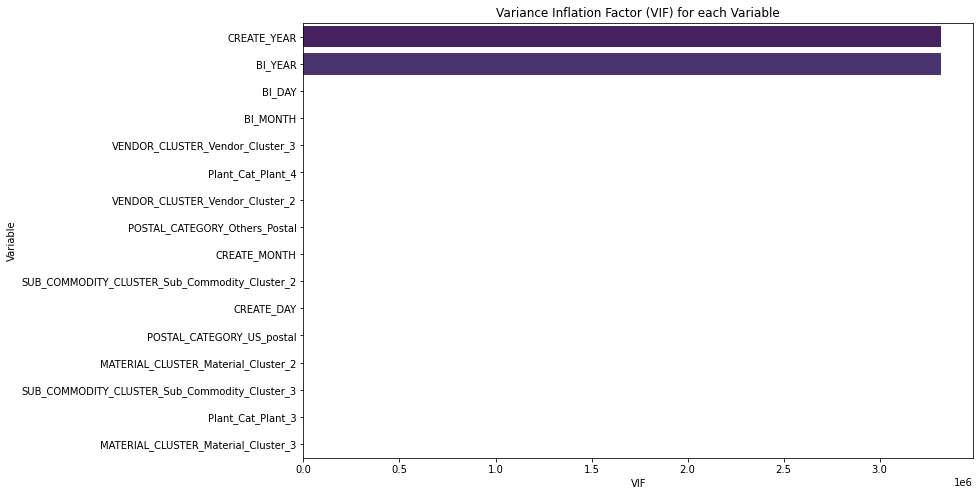

In [80]:
# Initialize an empty DataFrame to store VIF values
vif_data = pd.DataFrame()

# Assign the variable names from the oversampled data to the 'Variable' column in vif_data
vif_data["Variable"] = os_data_X.columns

# Calculate VIF for each variable and store in the 'VIF' column
vif_data["VIF"] = [variance_inflation_factor(os_data_X.values, i) for i in range(os_data_X.shape[1])]

# Sort the VIF values in descending order for better visualization and analysis
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Create a bar plot to visualize the VIF values
plt.figure(figsize=(12, 8))
sn.barplot(data=vif_data, y="Variable", x="VIF", palette="viridis")
plt.title("Variance Inflation Factor (VIF) for each Variable")
plt.xlabel("VIF")
plt.ylabel("Variable")

# Display the plot
plt.show()

In [81]:
# columns for machine learning model
cols = ['VENDOR_CLUSTER_Vendor_Cluster_2', 'VENDOR_CLUSTER_Vendor_Cluster_3',
       'POSTAL_CATEGORY_Others_Postal', 'POSTAL_CATEGORY_US_postal',
       'MATERIAL_CLUSTER_Material_Cluster_2',
       'MATERIAL_CLUSTER_Material_Cluster_3',
       'SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_2',
       'SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_3', 'Plant_Cat_Plant_3',
       'Plant_Cat_Plant_4', 'CREATE_YEAR', 'CREATE_MONTH', 'CREATE_DAY',
       'BI_YEAR', 'BI_MONTH', 'BI_DAY']

In [82]:
# Select specified columns (listed in 'cols') from the oversampled feature set 'os_data_X' to create a new DataFrame 'X'
X = os_data_X[cols]

# Extract the 'Delivery_Status' column from the oversampled target set 'os_data_y' to create the Series 'y'
y = os_data_y['Delivery_Status']

In [83]:
# Initialize and fit a logistic regression model using the features X and target variable y
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print the summary of the fitted logistic regression model
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.602965
         Iterations 7
                                        Results: Logit
Model:                        Logit                     Pseudo R-squared:          0.130       
Dependent Variable:           Delivery_Status           AIC:                       1409375.7790
Date:                         2023-12-04 18:02          BIC:                       1409567.3211
No. Observations:             1168678                   Log-Likelihood:            -7.0467e+05 
Df Model:                     15                        LL-Null:                   -8.1007e+05 
Df Residuals:                 1168662                   LLR p-value:               0.0000      
Converged:                    1.0000                    Scale:                     1.0000      
No. Iterations:               7.0000                                                           
---------------------------------------------------------------------------

In [84]:
#cols = ['COMP_CATEGORY_Low', 'POSTAL_CATEGORY_Low', 'POSTAL_CATEGORY_Medium', 'VENDOR_CATEGORY_Low',
       #'SUB_COMMODITY_CATEGORY_Low', 'SUB_COMMODITY_CATEGORY_Medium', 'PLANT_CATEGORY_Medium',
       #'CREATE_YEAR', 'CREATE_MONTH']
cols = ['VENDOR_CLUSTER_Vendor_Cluster_2', 'VENDOR_CLUSTER_Vendor_Cluster_3',
       'POSTAL_CATEGORY_Others_Postal', 'POSTAL_CATEGORY_US_postal',
       'MATERIAL_CLUSTER_Material_Cluster_2',
       'MATERIAL_CLUSTER_Material_Cluster_3',
       'SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_2',
       'SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_3', 'Plant_Cat_Plant_3',
       'Plant_Cat_Plant_4', 'CREATE_YEAR', 'CREATE_MONTH', 'CREATE_DAY',
       'BI_YEAR', 'BI_MONTH', 'BI_DAY']

In [85]:
# Example list of original column names before transformation
original_cols = ['CREATE_YEAR', 'CREATE_MONTH', 'CREATE_DAY', 'VENDOR_CLUSTER',
       'POSTAL_CATEGORY', 'MATERIAL_CLUSTER', 'SUB_COMMODITY_CLUSTER',
       'Plant_Cat', 'BI_YEAR', 'BI_MONTH', 'BI_DAY', 'Delivery_Status']

# Mapping to the transformed columns names used by the ColumnTransformer
transformed_cols = []
for col in original_cols:
    if 'CATEGORY' in col:
        # For categorical features that were one-hot encoded
        transformed_cols.extend(['oneht__' + col + '_' + str(level) for level in df[col].unique() if level != df[col].dropna().mode()[0]])
    else:
        # For the remainder of the features that were left untouched
        transformed_cols.append('remainder__' + col)

In [86]:
# Checking actual column names in os_data_X
print("Columns in os_data_X:", os_data_X.columns.tolist())

# Checking the column names you are trying to use
print("Columns being accessed:", cols)

# For example, if 'remainder__' is not required, you can remove that part
corrected_cols = [col.replace('remainder__', '') for col in cols]
print("Corrected columns:", corrected_cols)

Columns in os_data_X: ['VENDOR_CLUSTER_Vendor_Cluster_2', 'VENDOR_CLUSTER_Vendor_Cluster_3', 'POSTAL_CATEGORY_Others_Postal', 'POSTAL_CATEGORY_US_postal', 'MATERIAL_CLUSTER_Material_Cluster_2', 'MATERIAL_CLUSTER_Material_Cluster_3', 'SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_2', 'SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_3', 'Plant_Cat_Plant_3', 'Plant_Cat_Plant_4', 'CREATE_YEAR', 'CREATE_MONTH', 'CREATE_DAY', 'BI_YEAR', 'BI_MONTH', 'BI_DAY']
Columns being accessed: ['VENDOR_CLUSTER_Vendor_Cluster_2', 'VENDOR_CLUSTER_Vendor_Cluster_3', 'POSTAL_CATEGORY_Others_Postal', 'POSTAL_CATEGORY_US_postal', 'MATERIAL_CLUSTER_Material_Cluster_2', 'MATERIAL_CLUSTER_Material_Cluster_3', 'SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_2', 'SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_3', 'Plant_Cat_Plant_3', 'Plant_Cat_Plant_4', 'CREATE_YEAR', 'CREATE_MONTH', 'CREATE_DAY', 'BI_YEAR', 'BI_MONTH', 'BI_DAY']
Corrected columns: ['VENDOR_CLUSTER_Vendor_Cluster_2', 'VENDOR_CLUSTER_Vendor_Cluster_3', 'POSTA

In [88]:
# Initialize and fit a logistic regression model using the oversampled training data
logreg = LogisticRegression()
logreg.fit(os_data_X[corrected_cols], os_data_y['Delivery_Status'])

# Select the relevant columns from the transformed test data for prediction
X_test_selected = X_test_transformed[:, [os_data_X.columns.tolist().index(col) for col in corrected_cols]]

# Predict the target variable for both training and test datasets
y_train_pred = logreg.predict(os_data_X[corrected_cols])
y_test_pred = logreg.predict(X_test_selected)

# Calculate and print accuracy scores for both the training and test datasets
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y, y_train_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# Generate and print the confusion matrix for the test dataset
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix on Test Set:")
print(conf_matrix)

# Generate and print the classification report for the test dataset
class_report = classification_report(y_test, y_test_pred)
print("Classification Report on Test Set:")
print(class_report)

C:\Users\imuba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\imuba\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Test Accuracy: 0.9369
Train Accuracy: 0.6493
Confusion Matrix on Test Set:
[[200679    424]
 [ 13175   1109]]
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    201103
           1       0.72      0.08      0.14     14284

    accuracy                           0.94    215387
   macro avg       0.83      0.54      0.55    215387
weighted avg       0.92      0.94      0.91    215387



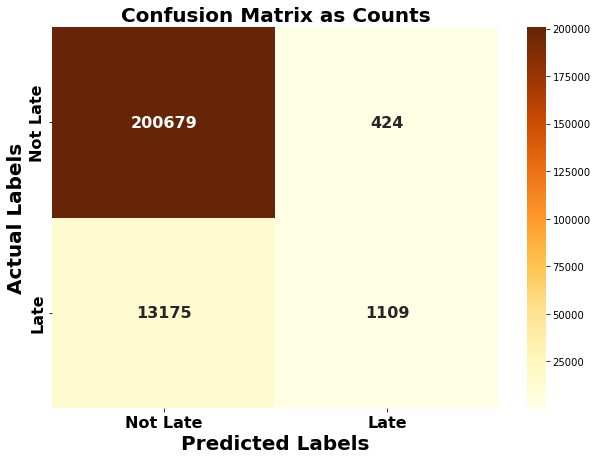

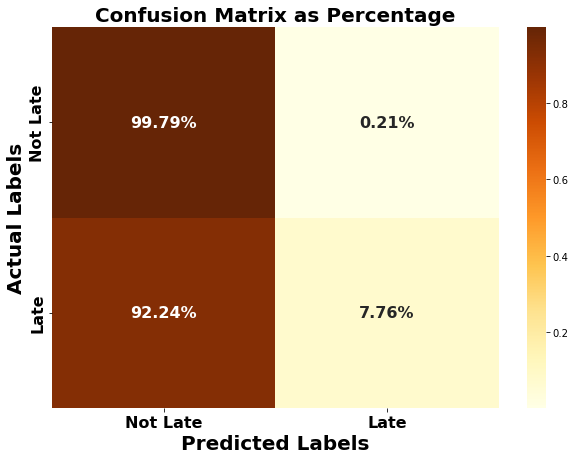

In [90]:
# The confusion matrix is visualized as counts
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Class names are defined
class_names = ['Not Late', 'Late']

# A heatmap is created to display the confusion matrix with actual counts
plt.figure(figsize=(10, 7))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrBr', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 16, "weight": 'bold'})
plt.title('Confusion Matrix as Counts', fontsize=20, fontweight='bold')
plt.ylabel('Actual Labels', fontsize=20, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=20, fontweight='bold')
plt.xticks([0.5, 1.5], ['Not Late', 'Late'], fontsize=16, fontweight='bold')
plt.yticks([0.5, 1.5], ['Not Late', 'Late'], va='center', fontsize=16, fontweight='bold')
plt.show()

# The confusion matrix is normalized and visualized as percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]  # Normalize the matrix
plt.figure(figsize=(10, 7))
sn.heatmap(conf_matrix_percentage, annot=True, fmt='.2%', cmap='YlOrBr', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 16, "weight": 'bold'})
plt.title('Confusion Matrix as Percentage', fontsize=20, fontweight='bold')
plt.ylabel('Actual Labels', fontsize=20, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=20, fontweight='bold')
plt.xticks([0.5, 1.5], ['Not Late', 'Late'], fontsize=16, fontweight='bold')
plt.yticks([0.5, 1.5], ['Not Late', 'Late'], va='center', fontsize=16, fontweight='bold')
plt.show()

C:\Users\imuba\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


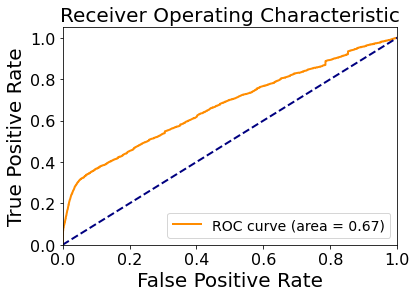

In [91]:
# Calculate the probabilities of the positive class for the test data
y_test_prob = logreg.predict_proba(X_test_selected)[:, 1]

# Compute the False Positive Rate, True Positive Rate, and thresholds for the ROC curve
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate the area under the ROC curve
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic', fontsize = 20)
plt.legend(loc="lower right", fontsize = 14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [92]:
# Extract the coefficients from the fitted logistic regression model
coefficients = logreg.coef_[0]

# Calculate the odds ratios for each coefficient
odds_ratios = np.exp(coefficients)

# Pair each feature name from corrected_cols with its corresponding odds ratio
feature_odds_ratios = dict(zip(corrected_cols, odds_ratios))

# Print the feature name and its odds ratio
for feature, odds_ratio in feature_odds_ratios.items():
    print(f"{feature}: Odds Ratio = {odds_ratio:.4f}")

VENDOR_CLUSTER_Vendor_Cluster_2: Odds Ratio = 0.9667
VENDOR_CLUSTER_Vendor_Cluster_3: Odds Ratio = 0.5132
POSTAL_CATEGORY_Others_Postal: Odds Ratio = 0.9223
POSTAL_CATEGORY_US_postal: Odds Ratio = 1.0649
MATERIAL_CLUSTER_Material_Cluster_2: Odds Ratio = 0.6425
MATERIAL_CLUSTER_Material_Cluster_3: Odds Ratio = 2.3592
SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_2: Odds Ratio = 0.9036
SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_3: Odds Ratio = 0.5307
Plant_Cat_Plant_3: Odds Ratio = 1.1037
Plant_Cat_Plant_4: Odds Ratio = 0.7673
CREATE_YEAR: Odds Ratio = 0.6196
CREATE_MONTH: Odds Ratio = 0.9212
CREATE_DAY: Odds Ratio = 0.9936
BI_YEAR: Odds Ratio = 1.6122
BI_MONTH: Odds Ratio = 1.2139
BI_DAY: Odds Ratio = 1.0435


# Random Forest

In [93]:
# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the Random Forest classifier on the oversampled training data
rf_classifier.fit(os_data_X, os_data_y.values.ravel())  # Using ravel() to convert the column vector to a 1d array

# Transform the test set using the same transformations as the training set
X_test_transformed = transformer.transform(X_test)

# Since the test set needs to be consistent with the columns used in training, make sure to select the same columns
# Note: If 'X_test' has already been transformed and aligned with 'os_data_X', this step may not be necessary.
X_test_transformed = pd.DataFrame(data=X_test_transformed, columns=all_columns)

# Predict on the transformed test data
y_test_pred = rf_classifier.predict(X_test_transformed)
y_train_pred = rf_classifier.predict(os_data_X)
# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(os_data_y, y_train_pred)
# Generate the confusion matrix for the test set predictions
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test_transformed)[:, 1])

# Output the performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print("Confusion Matrix on Test Set:")
print(conf_matrix)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))
print(f"ROC-AUC Score: {roc_auc:.4f}")

Test Accuracy: 0.9111
Train Accuracy: 0.9058
Confusion Matrix on Test Set:
[[193005   8098]
 [ 11043   3241]]
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95    201103
           1       0.29      0.23      0.25     14284

    accuracy                           0.91    215387
   macro avg       0.62      0.59      0.60    215387
weighted avg       0.90      0.91      0.91    215387

ROC-AUC Score: 0.6943


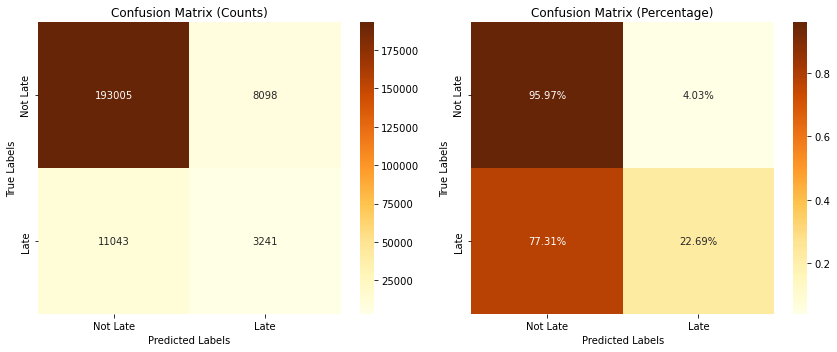

In [94]:
# Normalize the confusion matrix for percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1).reshape(-1, 1)
class_names = ['Not Late', 'Late']

# Set up the matplotlib figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix in count
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrBr', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix (Counts)')
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')

# Confusion matrix in percent
sn.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='YlOrBr', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Confusion Matrix (Percentage)')
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')

# Adjust layout for better fit and display the plot
plt.tight_layout()
plt.show()

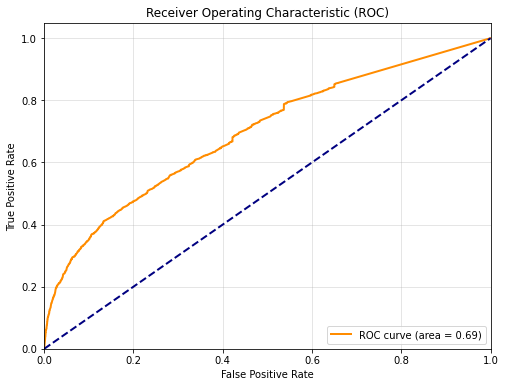

In [95]:
y_test_pred_probs = rf_classifier.predict_proba(X_test_transformed)[:, 1]

# Compute ROC curve and ROC area for the model
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_test_pred_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()

***Important Feature***

In [97]:
# Get feature importances from the random forest classifier
importances = rf_classifier.feature_importances_

# Get the indices of the sorted importances
sorted_indices = np.argsort(importances)[::-1]

# Organize them into a format for display
feature_ranking = [(all_columns[i], importances[i]) for i in sorted_indices]

# Print the feature ranking
print("Feature ranking:")
for i, (feat, importance) in enumerate(feature_ranking):
    print(f"{i + 1}. feature {feat} ({importance})")

# Alternatively, the feature importances converted into a DataFrame for better visualization and manipulation
feature_importances_df = pd.DataFrame({
    'Feature': all_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)

Feature ranking:
1. feature CREATE_DAY (0.255432874341858)
2. feature CREATE_YEAR (0.17617281092745019)
3. feature CREATE_MONTH (0.17279712542935)
4. feature MATERIAL_CLUSTER_Material_Cluster_3 (0.07343157808927826)
5. feature MATERIAL_CLUSTER_Material_Cluster_2 (0.04749643074109855)
6. feature POSTAL_CATEGORY_US_postal (0.042215010962598554)
7. feature SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_3 (0.04025700651625799)
8. feature VENDOR_CLUSTER_Vendor_Cluster_3 (0.04001918852531982)
9. feature SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_2 (0.032466050890762925)
10. feature Plant_Cat_Plant_4 (0.02905954404256961)
11. feature Plant_Cat_Plant_3 (0.026025225895407806)
12. feature VENDOR_CLUSTER_Vendor_Cluster_2 (0.022655058600523855)
13. feature BI_DAY (0.013769381480182995)
14. feature BI_MONTH (0.012176493805764813)
15. feature POSTAL_CATEGORY_Others_Postal (0.012028526626548115)
16. feature BI_YEAR (0.003997693125028598)
                                          Feature  Importance
12 

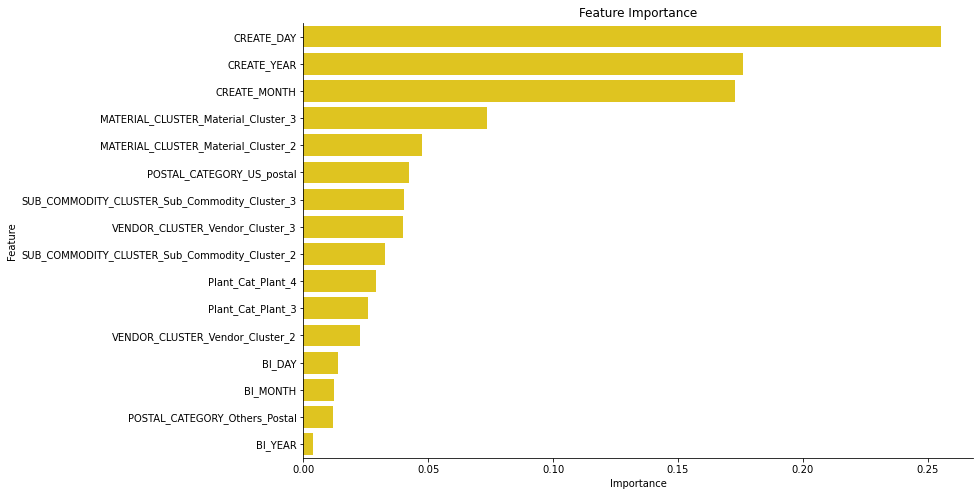

In [98]:
plt.figure(figsize=(12, 8))
sn.barplot(x='Importance', y='Feature', data=feature_importances_df, color='#FFDB00')

# Customize plot appearance
plt.xlabel('Importance')
plt.title('Feature Importance')

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

# Naive Bayes

In [99]:
#Instantiate the Gaussian Naive Bayes classifier
nb_model = GaussianNB()

# Fit the model on the oversampled training data
nb_model.fit(os_data_X, os_data_y.values.ravel())

#Predict on the test data
y_test_pred = nb_model.predict(X_test_transformed)

# Evaluate the model performance
train_accuracy = accuracy_score(os_data_y, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)

# Output the performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print("Confusion Matrix on Test Set:")
print(conf_matrix)
print("Classification Report on Test Set:")
print(class_report)

Test Accuracy: 0.8760
Train Accuracy: 0.9058
Confusion Matrix on Test Set:
[[183900  17203]
 [  9512   4772]]
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93    201103
           1       0.22      0.33      0.26     14284

    accuracy                           0.88    215387
   macro avg       0.58      0.62      0.60    215387
weighted avg       0.90      0.88      0.89    215387



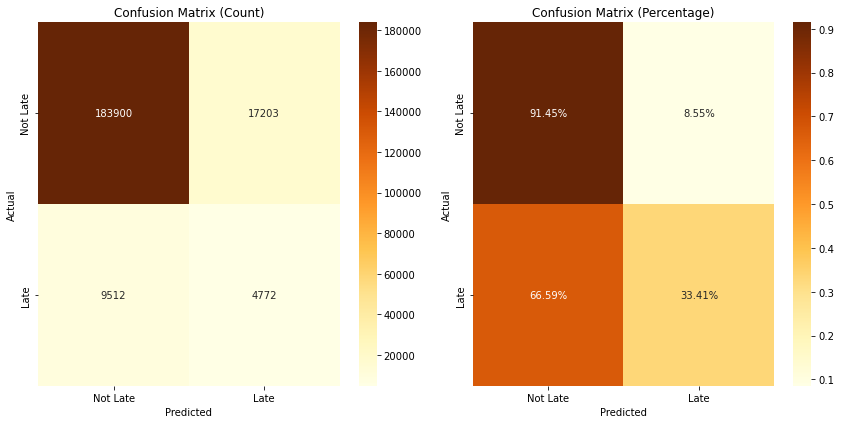

In [101]:
# Generate the confusion matrix in count form
cm_count = confusion_matrix(y_test, y_test_pred)

# Normalize the confusion matrix for percentage form
cm_percentage = cm_count.astype('float') / cm_count.sum(axis=1)[:, np.newaxis]

# Plotting the count confusion matrix
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sn.heatmap(cm_count, annot=True, fmt="d", cmap='YlOrBr', xticklabels=['Not Late', 'Late'], yticklabels=['Not Late', 'Late'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Count)')

# Plotting the percentage confusion matrix
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sn.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='YlOrBr', xticklabels=['Not Late', 'Late'], yticklabels=['Not Late', 'Late'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Percentage)')

plt.tight_layout()
plt.show()

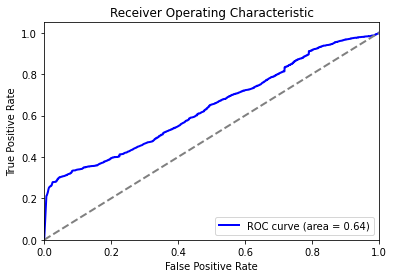

In [102]:
if hasattr(nb_model, "predict_proba"):
    y_probs = nb_model.predict_proba(X_test_transformed)[:, 1]
else:
    y_probs = nb_model.decision_function(X_test_transformed)

# Compute ROC curve and AUC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_probs)
roc_auc_nb = roc_auc_score(y_test, y_probs)

# Plotting
plt.figure()
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [103]:
means = nb_model.theta_  # Mean of each feature per class
variances = nb_model.sigma_  # Variance of each feature per class

# Create a DataFrame for mean
feature_info_mean = pd.DataFrame(data=means, columns=all_columns)

# Create a DataFrame for variance
feature_info_variance = pd.DataFrame(data=variances, columns=all_columns)

# Concatenate both DataFrames for a comprehensive view
feature_info = pd.concat([feature_info_mean.add_suffix('_mean'), feature_info_variance.add_suffix('_variance')], axis=1)

# Display the DataFrame
print(feature_info)

   VENDOR_CLUSTER_Vendor_Cluster_2_mean  VENDOR_CLUSTER_Vendor_Cluster_3_mean  \
0                              0.240169                              0.737106   
1                              0.241199                              0.633508   

   POSTAL_CATEGORY_Others_Postal_mean  POSTAL_CATEGORY_US_postal_mean  \
0                            0.235576                        0.498491   
1                            0.294659                        0.432403   

   MATERIAL_CLUSTER_Material_Cluster_2_mean  \
0                                  0.386936   
1                                  0.318415   

   MATERIAL_CLUSTER_Material_Cluster_3_mean  \
0                                  0.008724   
1                                  0.125513   

   SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_2_mean  \
0                                           0.590830    
1                                           0.580255    

   SUB_COMMODITY_CLUSTER_Sub_Commodity_Cluster_3_mean  Plant_Cat_Plant_3_mean  \

C:\Users\imuba\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `sigma_` was deprecated in 1.0 and will be removed in1.2. Use `var_` instead.
  warnings.warn(msg, category=FutureWarning)


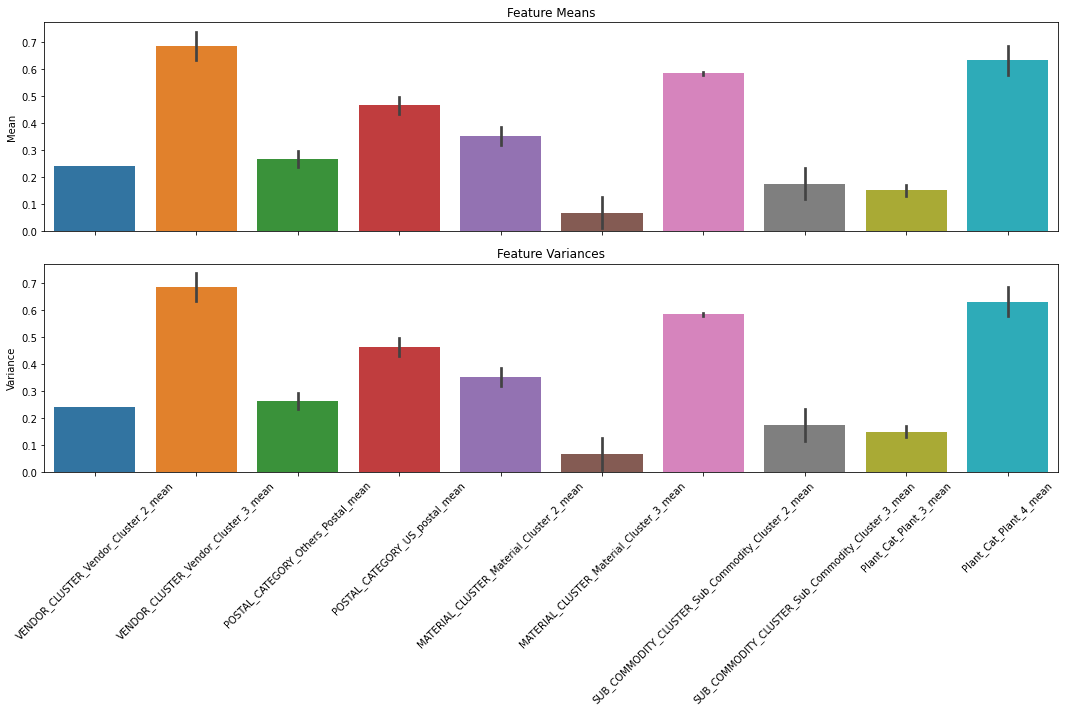

In [104]:
selected_features = feature_info.columns[:10]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# Visualize means
sn.barplot(data=feature_info[selected_features], ax=axes[0])
axes[0].set_title('Feature Means')
axes[0].set_ylabel('Mean')
axes[0].tick_params(axis='x', rotation=45)

# Visualize variances
sn.barplot(data=feature_info[selected_features], ax=axes[1])
axes[1].set_title('Feature Variances')
axes[1].set_ylabel('Variance')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Extreme Gradient Boosting

In [105]:
# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42, 
                            use_label_encoder=False, 
                            eval_metric='logloss')

# Train the classifier on the oversampled training data
xgb_clf.fit(os_data_X, os_data_y.values.ravel())

# Predict on the test set
y_pred = xgb_clf.predict(X_test_transformed)

# Evaluate the classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
train_accuracy = accuracy_score(os_data_y, y_train_pred)
print(f'Training Accuracy: {train_accuracy:.4f}')
# Display classification report
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Test Accuracy: 0.9240
Training Accuracy: 0.9058
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    201103
           1       0.40      0.28      0.33     14284

    accuracy                           0.92    215387
   macro avg       0.67      0.63      0.65    215387
weighted avg       0.91      0.92      0.92    215387

[[194966   6137]
 [ 10238   4046]]


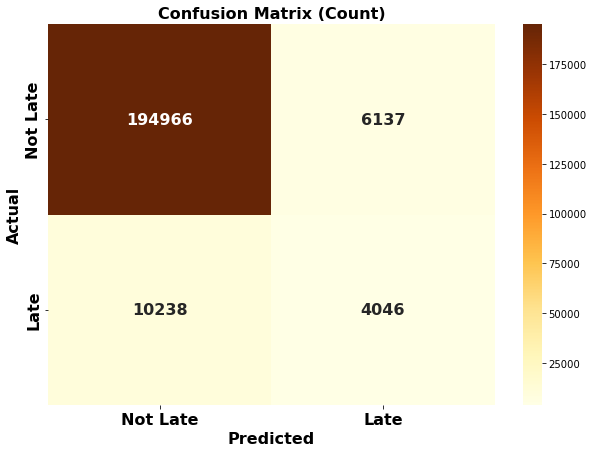

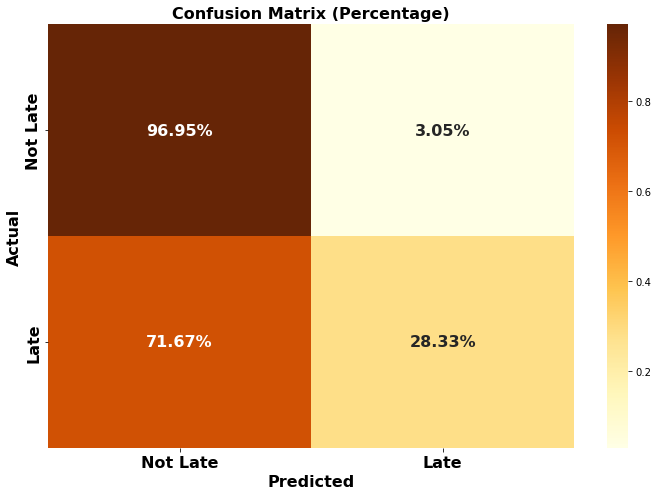

In [106]:
# Generate the confusion matrix in count form
cm_count = conf_matrix

# Normalize the confusion matrix for percentage form
cm_percentage = cm_count.astype('float') / cm_count.sum(axis=1)[:, np.newaxis]

# Plotting the count confusion matrix
plt.figure(figsize=(10, 7))
sn.heatmap(cm_count, annot=True, fmt="d", cmap='YlOrBr', annot_kws={"size": 16, "weight": 'bold'})

plt.xticks([0.5, 1.5], ['Not Late', 'Late'], fontsize=16, fontweight='bold')
plt.yticks([0.5, 1.5], ['Not Late', 'Late'], va='center', fontsize=16, fontweight='bold')

plt.ylabel('Actual', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=16, fontweight='bold')
plt.title('Confusion Matrix (Count)', fontsize=16, fontweight='bold')

# Plotting the percentage confusion matrix
plt.figure(figsize=(10, 7))
sn.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='YlOrBr', annot_kws={"size": 16, "weight": 'bold'})

plt.xticks([0.5, 1.5], ['Not Late', 'Late'], fontsize=16, fontweight='bold')
plt.yticks([0.5, 1.5], ['Not Late', 'Late'], va='center', fontsize=16, fontweight='bold')

plt.ylabel('Actual', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=16, fontweight='bold')
plt.title('Confusion Matrix (Percentage)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

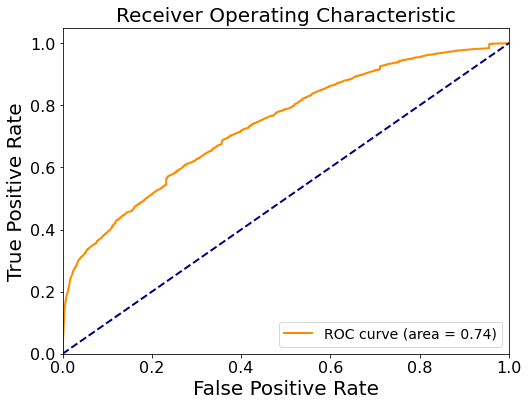

In [107]:
y_pred_proba = xgb_clf.predict_proba(X_test_transformed)[:,1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic', fontsize = 20)
plt.legend(loc="lower right", fontsize = 14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

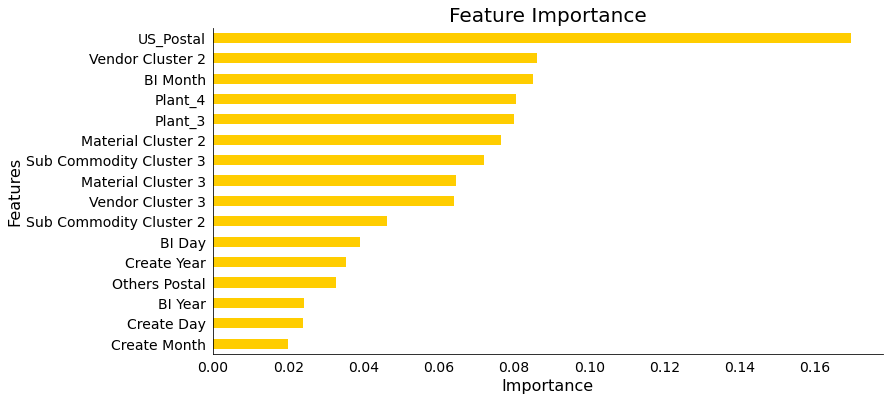

In [108]:
feature_importances = xgb_clf.feature_importances_

# Create a pandas series with feature names and their importance
importances = pd.Series(feature_importances, index=all_columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=True)

# Define new tick labels
new_tick_labels = [
    'Material Cluster 3', 'Sub Commodity Cluster 3', 'Create Year', 'Material Cluster 2',
    'Plant_4', 'US_Postal', 'Vendor Cluster 3', 'Vendor Cluster 2', 'Sub Commodity Cluster 2',
    'Plant_3', 'BI Month','Others Postal' , 'Create Month', 'BI Year', 'BI Day', 'Create Day'
]


sorted_new_tick_labels = [new_tick_labels[all_columns.index(feature)] for feature in sorted_importances.index]

# Visualize the feature importances
plt.figure(figsize=(12, 6))
sorted_importances.plot(kind='barh', color='#FFCD00')
plt.title('Feature Importance', fontsize=20)
plt.ylabel('Features', fontsize=16)
plt.xlabel('Importance', fontsize=16)

# Set the new tick labels with the desired font size
plt.yticks(range(len(sorted_new_tick_labels)), sorted_new_tick_labels, fontsize=14)
plt.xticks(fontsize=14)

# Remove xticks and yticks as requested
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)  
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True) 

# Retrieve the current axes and hide the top and right spines
current_axes = plt.gca()
for spine in ['top', 'right']:
    current_axes.spines[spine].set_visible(False)

# Show the plot
plt.show()